In [2]:
import timm
import open_clip
import os
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'
import torch
torch.set_grad_enabled(False)
import psutil
from lavis.models.eva_vit import create_eva_vit_g
from lavis.common.registry import registry
from omegaconf import OmegaConf
from PIL import Image
from tqdm import tqdm
import gc
import cv2
cpu_device = torch.device('cpu')
gpu_device = torch.device('cuda')

In [5]:
def print_mem_stats():
    mem = psutil.virtual_memory()
    total_system_memory = mem.total / (1024 ** 2)
    used_system_memory = mem.used / (1024 ** 2)
    total_gpu_memory = torch.cuda.get_device_properties(0).total_memory / (1024 ** 2)
    reserved_gpu_memory = torch.cuda.memory_reserved(0) / (1024 ** 2)
    allocated_gpu_memory = torch.cuda.memory_allocated(0) / (1024 ** 2)
    percent_gpu_total = (allocated_gpu_memory / total_gpu_memory)*100
    percent_gpu_reserved = (reserved_gpu_memory / total_gpu_memory)*100
    percent_cpu_total = (used_system_memory / total_system_memory)*100
    print(f"mem used gpu: {allocated_gpu_memory:.2f} MB, reserved gpu: {reserved_gpu_memory:.2f}MB -> {percent_gpu_total:.2f}% of total, {percent_gpu_reserved:.2f}% reserved")
    print(f"mem used cpu: {used_system_memory:.2f} MB -> {percent_cpu_total:.2f}% of total")

print_mem_stats()

mem used gpu: 0.00 MB, reserved gpu: 0.00MB -> 0.00% of total, 0.00% reserved
mem used cpu: 4330.40 MB -> 8.99% of total


In [3]:
import pickle
# use the outputs from step 1
with open('outputs.pkl', 'rb') as f:
    outputs = pickle.load(f)

In [4]:
visual_encoder = create_eva_vit_g(512, precision='fp32').to(gpu_device)
print_mem_stats()

Position interpolate from 16x16 to 36x36
mem used gpu: 3766.48 MB, reserved gpu: 3784.00MB -> 16.75% of total, 16.82% reserved
mem used cpu: 4081.98 MB -> 8.47% of total


In [5]:
cosine_similarity = torch.nn.CosineSimilarity(dim=-1)

# calculate the global feature vector
scene_img = outputs["sceneshotcam"]
print(scene_img.shape)
scene_tensor = torch.tensor(scene_img).permute(2, 0, 1).unsqueeze(0).float().to(gpu_device)

print(scene_tensor.shape)
global_feat = visual_encoder.forward_features(scene_tensor)
global_feat = global_feat.half()
global_feat = global_feat.mean(1)
global_feat = torch.nn.functional.normalize(global_feat, dim=-1)
FEAT_DIM = global_feat.shape[-1]
print_mem_stats()

(512, 512, 3)
torch.Size([1, 3, 512, 512])
mem used gpu: 3777.60 MB, reserved gpu: 4044.00MB -> 16.80% of total, 17.98% reserved
mem used cpu: 4229.97 MB -> 8.78% of total


In [6]:
import numpy as np

point_feature_cameras = ['sceneshotcam', 'apple', 'milk', 'cereal', 'bread', 'banana', 'bin', 'table', 'ur5e', 'panda']
specific_views = ['panda', 'cereal', 'milk', 'bread', 'apple', 'ur5e', 'banana', 'bin', 'table']#list(set(point_feature_cameras) - {"sceneshotcam"} - {f"genpurp__{i}" for i in range(1,6)})
feat_per_obj = []
obj_sim_per_unit_area = []
for view in tqdm(specific_views):
    # crop the image to the bounding box and run it through the visual encoder to get the feature vector for the object
    obj_img = outputs[view]
    # obj_img = cv2.resize(obj_img, (224, 224))
    # obj_img = np.array(Image.open(f"rocobench/test_images/ground truths/{view}.png").convert("RGB").resize((512, 512)))
    img_roi = torch.tensor(obj_img).permute(2, 0, 1).unsqueeze(0).float().to(gpu_device)
    roifeat = visual_encoder.forward_features(img_roi)
    roifeat = roifeat.half().cuda()
    roifeat = roifeat.mean(1)
    roifeat = torch.nn.functional.normalize(roifeat, dim=-1)
    feat_per_obj.append(roifeat)

    # calculate the cosine similarity between the global feature vector and the feature vector for the object and save that as well
    _sim = cosine_similarity(global_feat, roifeat)
    obj_sim_per_unit_area.append(_sim)

    torch.cuda.empty_cache()

visual_encoder = None
del visual_encoder
gc.collect()
torch.cuda.empty_cache()

print_mem_stats()

100%|██████████| 9/9 [00:03<00:00,  2.30it/s]


mem used gpu: 14.16 MB, reserved gpu: 42.00MB -> 0.06% of total, 0.19% reserved
mem used cpu: 4261.21 MB -> 8.84% of total


In [7]:
print("global feature shape:", global_feat.shape)

global feature shape: torch.Size([1, 1408])


In [8]:
scores = torch.cat(obj_sim_per_unit_area).to(gpu_device)
feat_per_obj = torch.cat(feat_per_obj, dim=0).to(gpu_device)
# norm_feat_per_obj = torch.nn.functional.normalize(feat_per_obj, p=2, dim=1)

# get the cosine simixlarity between the features of each object. This will be a square matrix where the (i, j)th entry is the cosine similarity between the ith and jth objects
mask_sim_mat = torch.nn.functional.cosine_similarity(
    feat_per_obj[:, :, None], feat_per_obj.t()[None, :, :]
)
mask_sim_mat_untouched = mask_sim_mat.clone()
print(mask_sim_mat)
mask_sim_mat.fill_diagonal_(0.0) # set the diagonal to 0 because we don't want to consider the similarity between the same object
mask_sim_mat = mask_sim_mat.mean(1)  # avg sim of each mask with each other mask
softmax_scores = scores.cuda() - mask_sim_mat # subtracting the object-object relevance (which can be thought of as the relevance of the object in context of the other objects) object-scene similarity (which is kind of like global relevance) gives how much more or less important that object is than all the other objects
softmax_scores = torch.nn.functional.softmax(softmax_scores, dim=0) # apply softmax to get the final scores
print_mem_stats()

print(specific_views)
print(softmax_scores)

tensor([[1.0010, 0.9434, 0.9692, 0.9854, 0.9736, 0.9717, 0.9727, 0.9766, 0.9771],
        [0.9434, 1.0010, 0.9497, 0.9517, 0.9795, 0.9307, 0.9663, 0.9692, 0.9619],
        [0.9692, 0.9497, 0.9995, 0.9785, 0.9790, 0.9648, 0.9883, 0.9795, 0.9873],
        [0.9854, 0.9517, 0.9785, 1.0000, 0.9844, 0.9800, 0.9844, 0.9790, 0.9849],
        [0.9736, 0.9795, 0.9790, 0.9844, 1.0000, 0.9663, 0.9902, 0.9858, 0.9893],
        [0.9717, 0.9307, 0.9648, 0.9800, 0.9663, 1.0000, 0.9663, 0.9541, 0.9668],
        [0.9727, 0.9663, 0.9883, 0.9844, 0.9902, 0.9663, 1.0000, 0.9902, 0.9946],
        [0.9766, 0.9692, 0.9795, 0.9790, 0.9858, 0.9541, 0.9902, 1.0010, 0.9922],
        [0.9771, 0.9619, 0.9873, 0.9849, 0.9893, 0.9668, 0.9946, 0.9922, 1.0010]],
       device='cuda:0', dtype=torch.float16)
mem used gpu: 14.16 MB, reserved gpu: 42.00MB -> 0.06% of total, 0.19% reserved
mem used cpu: 4230.39 MB -> 8.78% of total
['panda', 'cereal', 'milk', 'bread', 'apple', 'ur5e', 'banana', 'bin', 'table']
tensor([0.112

In [9]:
torch.save(mask_sim_mat_untouched, "figure_data/blip_noneva_rendfet_sim_square.pt")

In [9]:
print(feat_per_obj.shape)

torch.Size([9])


In [10]:
pixelwise_features = torch.zeros(outputs['xyz_pts'].shape[0], FEAT_DIM, dtype=torch.half)#global_feat.repeat((xyz_pts.shape[0], 1))
print(pixelwise_features.shape)#torch.zeros(xyz_pts.shape[0], FEAT_DIM, dtype=torch.half)
print_mem_stats()

torch.Size([2615298, 1408])
mem used gpu: 14.16 MB, reserved gpu: 42.00MB -> 0.06% of total, 0.19% reserved
mem used cpu: 11434.00 MB -> 23.73% of total


In [11]:
pixelwise_features = pixelwise_features.to(gpu_device)
for objidx in range(len(specific_views)):
    _weighted_feat = (
        softmax_scores[objidx] * global_feat + (1 - softmax_scores[objidx]) * feat_per_obj[objidx]
    )
    _weighted_feat = torch.nn.functional.normalize(_weighted_feat, dim=-1)
    pixelwise_features[outputs['segmentation_pts'][specific_views[objidx]], :] = feat_per_obj[objidx]
    # second normalization is unnecessary because all pixels in each object receive the same feature, and each point is only interacted with once.
    # instead, we will normalize the features after voxel aggregation

print_mem_stats()

mem used gpu: 7037.67 MB, reserved gpu: 7082.00MB -> 31.29% of total, 31.49% reserved
mem used cpu: 4471.89 MB -> 9.28% of total


In [12]:
# we have to save the pixelwise features as a tensor so that we can do the voxel grid sampling
# unfortunately, that doesn't work with the version of pytorch that we use this notebook
# WIP
torch.save(pixelwise_features.cpu(), "blip_noneva_pixelwise_rendfet_features.pt")

In [13]:
# xyz_pts = torch.tensor(xyz_pts)

# pixelwise_features = pixelwise_features.unsqueeze(0).float()
# xyz_pts = xyz_pts.unsqueeze(0).float()
# pixelwise_features = pixelwise_features.permute(0, 2, 1) # 1, PCL, feat_dim -> 1, feat_dim, PCL
# xyz_pts = xyz_pts.permute(0, 2, 1)
# pixelwise_features = torch.nn.functional.interpolate(pixelwise_features, [15000], mode="nearest")
# xyz_pts = torch.nn.functional.interpolate(xyz_pts, [15000], mode="nearest")
# pixelwise_features = pixelwise_features.permute(0, 2, 1).to(cpu_device)
# xyz_pts = xyz_pts.permute(0, 2, 1)
# print_mem_stats()

mem used gpu: 10.45 MB, reserved gpu: 19244.00MB -> 0.05% of total, 85.56% reserved
mem used cpu: 3575.56 MB -> 7.42% of total


In [15]:
mask_sim_mat = None
softmax_scores = None
feat_per_obj = None
scores = None
outputs = None
obj_sim_per_unit_area = None
del mask_sim_mat
del softmax_scores
del feat_per_obj
del scores
del outputs
del obj_sim_per_unit_area
gc.collect()
torch.cuda.empty_cache()
print_mem_stats()

mem used gpu: 10.42 MB, reserved gpu: 24.00MB -> 0.05% of total, 0.11% reserved
mem used cpu: 3488.62 MB -> 7.24% of total


In [3]:
pixelwise_features = torch.load("blip_noneva_pixelwise_rendfet_features.pt").unsqueeze(0).float()
xyz_pts = torch.load("blip_noneva_pixelwise_rendfet_xyz.pt").unsqueeze(0).float()

In [6]:
ckpt_path = "checkpoints/pretrain_blip2_sam_flant5xl_v2.pth"
model_cfg = {
    "arch": "blip2_t5",
    "model_type": "pretrain_flant5xl",
    "use_grad_checkpoint": False,
}
model_cfg = OmegaConf.create(model_cfg)
print_mem_stats()

mem used gpu: 0.00 MB, reserved gpu: 0.00MB -> 0.00% of total, 0.00% reserved
mem used cpu: 4364.71 MB -> 9.06% of total


In [7]:
model = registry.get_model_class("blip2_t5").from_pretrained(model_type="pretrain_flant5xl")
print_mem_stats()

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

mem used gpu: 0.46 MB, reserved gpu: 2.00MB -> 0.00% of total, 0.01% reserved
mem used cpu: 20112.35 MB -> 41.74% of total


In [8]:
checkpoint = torch.load(ckpt_path, map_location="cpu")
print_mem_stats()

mem used gpu: 0.46 MB, reserved gpu: 2.00MB -> 0.00% of total, 0.01% reserved
mem used cpu: 24371.35 MB -> 50.57% of total


In [9]:
model.load_state_dict(checkpoint["model"], strict=False)
print_mem_stats()

mem used gpu: 0.46 MB, reserved gpu: 2.00MB -> 0.00% of total, 0.01% reserved
mem used cpu: 24370.30 MB -> 50.57% of total


In [10]:
model.eval()
model.to(cpu_device)
print_mem_stats()

mem used gpu: 0.46 MB, reserved gpu: 2.00MB -> 0.00% of total, 0.01% reserved
mem used cpu: 24371.53 MB -> 50.57% of total


In [11]:
processor_cfg = {"name": "blip_question", "prompt": ""}
processor_cfg = OmegaConf.create(processor_cfg)
text_processor = registry.get_processor_class(processor_cfg.name).from_config(processor_cfg)
print_mem_stats()

mem used gpu: 0.46 MB, reserved gpu: 2.00MB -> 0.00% of total, 0.01% reserved
mem used cpu: 24373.59 MB -> 50.58% of total


In [12]:
outfeat = pixelwise_features.to(cpu_device)
xyz_pts = xyz_pts.to(cpu_device)
prompt = text_processor("Describe the 3D scene in one sentence.")

model_inputs = {"text_input": prompt, "pc_feat": outfeat, "pc": xyz_pts}
model_outputs = model.predict_answers(
    samples=model_inputs,
    max_len=50,
    length_penalty=1.2,
    repetition_penalty=1.5,
)
model_outputs = model_outputs[0]
print(model_outputs)
print_mem_stats()

/opt/conda/envs/eval/lib/python3.8/site-packages/transformers/generation/configuration_utils.py:418: UserWarning: `num_beams` is set to 1. However, `length_penalty` is set to `1.2` -- this flag is only used in beam-based generation modes. You should set `num_beams>1` or unset `length_penalty`.
  warnings.warn(


<pad> The couch is far away from the radiator.</s>
mem used gpu: 0.46 MB, reserved gpu: 202.00MB -> 0.00% of total, 0.90% reserved
mem used cpu: 24486.39 MB -> 50.81% of total


In [13]:
print(xyz_pts.shape)
print(pixelwise_features.shape)

torch.Size([1, 17890, 3])
torch.Size([1, 17890, 1408])


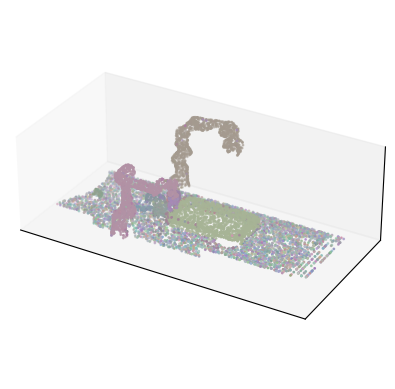

In [14]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

ax = plt.figure().add_subplot(111, projection="3d")
tsne = TSNE(n_components=3, random_state=0, learning_rate=200, init="random")
idx = np.random.choice(outfeat.shape[1], 10000)
pc_feature = outfeat[:, idx, :]
pc_points = xyz_pts[:, idx, :]
pc_feature = pc_feature.squeeze(0).cpu().numpy()  # (N, 1408)
pc_points = pc_points.squeeze(0).cpu().numpy()  # (N, 3)
pc_feature = tsne.fit_transform(pc_feature)  # (N, 3)
pc_feature = (pc_feature - pc_feature.min()) / (pc_feature.max() - pc_feature.min() + 1e-6) # normalize
ax.scatter(pc_points[:, 0], pc_points[:, 1], pc_points[:, 2], c=pc_feature, s=1)
ax.set_aspect("equal")
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
plt.show()

In [31]:
alternative_feats = torch.load("/home/owenburns88/3D-LLM/3DLLM_BLIP2-base/assets/scene0480_00.pt")
alternative_pcs = torch.from_numpy(np.load("/home/owenburns88/3D-LLM/3DLLM_BLIP2-base/assets/scene0480_00.npy"))
prompt = text_processor("Agent 1: What's the room like??.")
# model_inputs = {"text_input": prompt, "pc_feat": outfeat_downsampled, "pc": xyz_pts_downsampled}
model_inputs = {"text_input": prompt, "pc_feat": alternative_feats.unsqueeze(0), "pc": alternative_pcs.long().unsqueeze(0)}
model_outputs = model.predict_answers(
    samples=model_inputs,
    max_len=50,
    length_penalty=1.2,
    repetition_penalty=1.5,
)
model_outputs = model_outputs[0]
print(model_outputs)
print_mem_stats()

/opt/conda/envs/eval/lib/python3.8/site-packages/transformers/generation/configuration_utils.py:418: UserWarning: `num_beams` is set to 1. However, `length_penalty` is set to `1.2` -- this flag is only used in beam-based generation modes. You should set `num_beams>1` or unset `length_penalty`.
  warnings.warn(


<pad> Agent 2: It's a cozy room with white walls and furniture. There are two chairs in the corner, one of which is near an end table</s>
mem used gpu: 10.88 MB, reserved gpu: 204.00MB -> 0.05% of total, 0.91% reserved
mem used cpu: 24381.20 MB -> 50.59% of total


In [3]:
import torch
import numpy as np
alternative_feats = torch.load("/home/owenburns88/3D-LLM/3DLLM_BLIP2-base/assets/scene0480_00.pt")
alternative_pcs = torch.from_numpy(np.load("/home/owenburns88/3D-LLM/3DLLM_BLIP2-base/assets/scene0480_00.npy"))


print(f"x -> [{alternative_pcs[:,0].min()}, {alternative_pcs[:,0].max()}]")
print(f"y -> [{alternative_pcs[:,1].min()}, {alternative_pcs[:,1].max()}]")
print(f"z -> [{alternative_pcs[:,2].min()}, {alternative_pcs[:,2].max()}]")

x -> [66, 206]
y -> [5, 174]
z -> [116, 152]


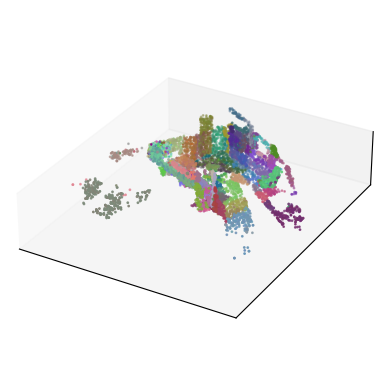

In [30]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# the t-sne pointcloud for one of the objaverse scenes, as a visual sanity check

outfeat = alternative_feats.unsqueeze(0)
xyz_pts = alternative_pcs.long().unsqueeze(0)

ax = plt.figure().add_subplot(111, projection="3d")
tsne = TSNE(n_components=3, random_state=0, learning_rate=200, init="random")
idx = np.random.choice(outfeat.shape[1], 10000)
pc_feature = outfeat[:, idx, :]
pc_points = xyz_pts[:, idx, :]
pc_feature = pc_feature.squeeze(0).cpu().numpy()  # (N, 1408)
pc_feature = tsne.fit_transform(pc_feature)  # (N, 3)
pc_feature = (pc_feature - pc_feature.min()) / (pc_feature.max() - pc_feature.min() + 1e-6)
pc_points = pc_points.squeeze(0).cpu().numpy()  # (N, 3)
ax.scatter(pc_points[:, 0], pc_points[:, 1], pc_points[:, 2], c=pc_feature, s=1)
ax.set_aspect("equal")
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
plt.show()